In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2024-08-13 17:24:12.475755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and preprocess data  
df_paris = pd.read_csv('../Resources/DataFrames/Cleaned/completed_paris_2024.csv')
df = pd.read_csv('../Resources/DataFrames/Cleaned/completed_dataframe_all_olympic_years.csv')
df = df.dropna(subset=['Medal Count'])
features = df.drop(columns=['NOC', 'Year', 'Country Name', 'Medal Count', 'Bronze Count', 'Silver Count', 'Gold Count'])
features.fillna(features.mean(), inplace=True)

In [3]:
target = df['Medal Count']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

In [7]:
print(f"Random Forest - MAE: {rf_mae:.2f}, R2: {rf_r2:.2f}")

Random Forest - MAE: 2.95, R2: 0.69


In [8]:
# Plot feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

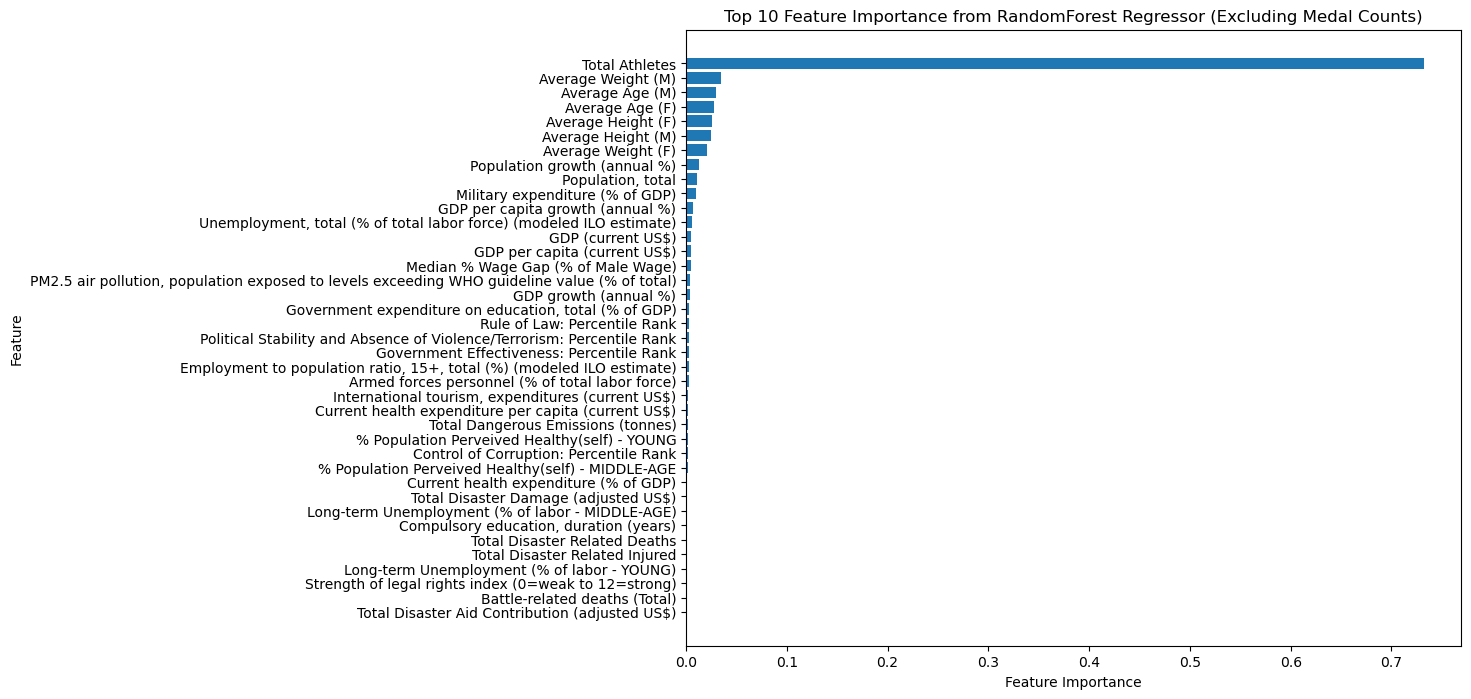

In [9]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance from RandomForest Regressor (Excluding Medal Counts)')
plt.gca().invert_yaxis()
plt.show()

In [10]:
# Neural Network Model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
nn_model.compile(optimizer='adam', loss='mean_absolute_error')

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1336 - val_loss: 3.6091
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0234 - val_loss: 3.3590
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5512 - val_loss: 2.9043
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9558 - val_loss: 2.5621
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5340 - val_loss: 2.3339
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6473 - val_loss: 2.2438
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5895 - val_loss: 2.1735
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4448 - val_loss: 2.1749
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3187 - val_loss: 2.1816
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1320 - val_loss: 2.1533
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4071 - val_loss: 2.1399
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1

In [14]:
test_loss = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network - MAE on Test Data: {test_loss:.2f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 2.9470
Neural Network - MAE on Test Data: 2.58


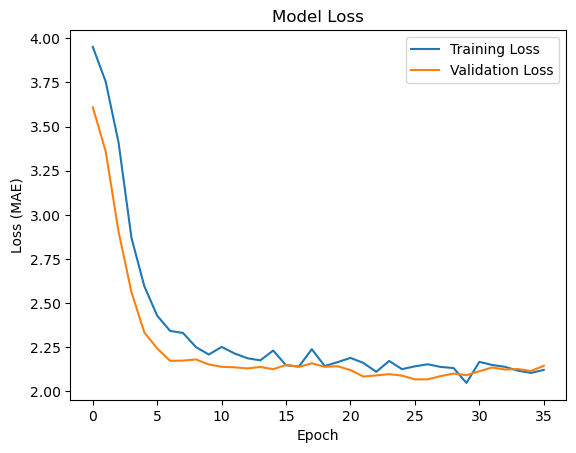

In [15]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend(loc='upper right')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


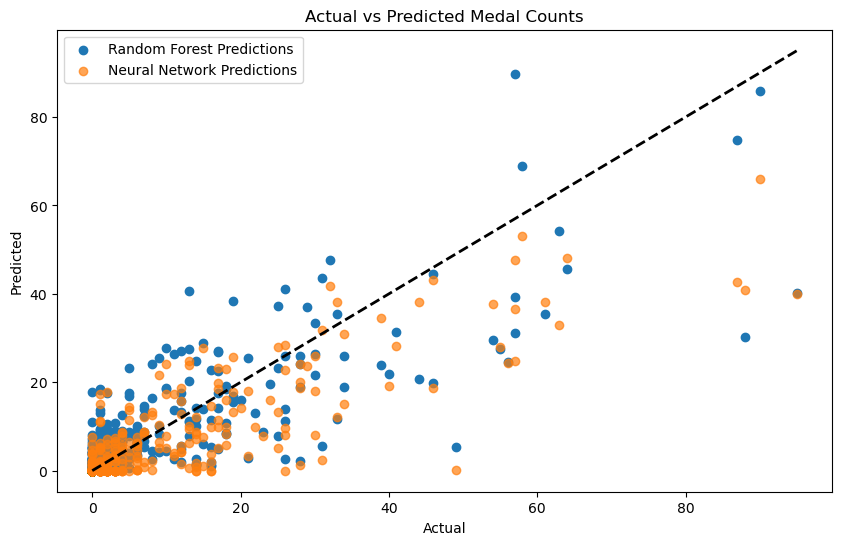

In [16]:
# Compare Predictions vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, label='Random Forest Predictions')
plt.scatter(y_test, nn_model.predict(X_test_scaled), label='Neural Network Predictions', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Medal Counts')
plt.legend()
plt.show()

In [17]:
# Save the model to an HDF5 file
nn_model.save('Initial_Model.h5')

# other models



# predictions for Paris

In [33]:
# all_all.to_csv('../Resources/DataFrames/Cleaned/completed_dataframe_all_olympic_years.csv', index=False, header=True)
olympic_years_FINAL = pd.read_csv('../Resources/DataFrames/Cleaned/completed_dataframe_all_olympic_years.csv')
print(olympic_years_FINAL.shape)
olympic_years_FINAL.tail(20)

(4985, 46)


,NOC,Year,Country Name,Total Athletes,Medal Count,Gold Count,Silver Count,Bronze Count,Average Age (M),Average Height (M),...,Total Disaster Aid Contribution (adjusted US$),Total Disaster Related Deaths,Total Disaster Related Injured,Total Disaster Damage (adjusted US$),Total Dangerous Emissions (tonnes),Median % Wage Gap (% of Male Wage),Long-term Unemployment (% of labor - YOUNG),Long-term Unemployment (% of labor - MIDDLE-AGE),% Population Perveived Healthy(self) - YOUNG,% Population Perveived Healthy(self) - MIDDLE-AGE
4965,YUG,2010,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,549.0,2.0,120.0,184815.0,174.745014,NaN,NaN,NaN,NaN,NaN
4966,YUG,2012,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,171.871884,NaN,NaN,NaN,NaN,NaN
4967,YUG,2014,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,146.610556,NaN,NaN,NaN,NaN,NaN
4968,YUG,2016,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,166.045259,NaN,NaN,NaN,NaN,NaN
4969,ZAM,1960,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4970,ZAM,1976,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4971,ZAM,1994,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4972,ZAM,1998,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4973,ZAM,2002,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4974,ZAM,2006,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
print(df_paris.shape)
df_paris.head(1)

(206, 14)


,Year,NOC,Country Name,Total Athletes,Medal Count,Gold Count,Silver Count,Bronze Count,Average Age (M),Average Height (M),Average Weight (M),Average Age (F),Average Height (F),Average Weight (F)
0,2024,ARM,Armenia,15,4.0,0.0,3.0,1.0,27.384615,186.5,NaN,25.5,NaN,NaN


In [35]:
# combined_2024 = pd.merge(olympic_years_FINAL, df_paris, on=['Year', 'NOC', 'Country Name'], how='left')
combined = pd.concat([olympic_years_FINAL, df_paris], ignore_index=True, sort=False)
print(combined.shape)

(5191, 46)


In [36]:
combined.columns

Index(['NOC', 'Year', 'Country Name', 'Total Athletes', 'Medal Count',
       'Gold Count', 'Silver Count', 'Bronze Count', 'Average Age (M)',
       'Average Height (M)', 'Average Weight (M)', 'Average Age (F)',
       'Average Height (F)', 'Average Weight (F)',
       'Armed forces personnel (% of total labor force)',
       'Compulsory education, duration (years)',
       'Control of Corruption: Percentile Rank',
       'Current health expenditure (% of GDP)',
       'Current health expenditure per capita (current US$)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'GDP per capita growth (annual %)',
       'Government Effectiveness: Percentile Rank',
       'Government expenditure on education, total (% of GDP)',
       'International tourism, expenditures (current US$)',
       'Military expenditure (% of GDP)',
       'PM2.5 air pollution, population expo

In [21]:
# # features_paris = 2024 data for predicting - > paris_test_scaled -> target_paris
# #        still has other medal counts

# # olympic_years_FINAL has all other data

# # Load and preprocess data  
# target = combined['Medal Count']

# olympic_years_FINAL = olympic_years_FINAL.dropna(subset=['Medal Count'])
# # trying to include Country Name and year
# features = olympic_years_FINAL.drop(columns=['NOC', 'Medal Count', 'Bronze Count', 'Silver Count', 'Gold Count'])



In [41]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_series = ['Country Name'] #this is a list
ofy_df_dummies = pd.get_dummies(olympic_years_FINAL, columns=categorical_series)
# ofy_df_dummies.nunique()
# might need to remove medal count from here

In [42]:
# take off 2024 to use for predicitons later 
df_2024 = ofy_df_dummies[ofy_df_dummies['Year'] == 2024].copy()
no_2024 = ofy_df_dummies[ofy_df_dummies['Year'] != 2024]

In [43]:
no_2024.columns

Index(['NOC', 'Year', 'Total Athletes', 'Medal Count', 'Gold Count',
       'Silver Count', 'Bronze Count', 'Average Age (M)', 'Average Height (M)',
       'Average Weight (M)',
       ...
       'Country Name_Uruguay', 'Country Name_Uzbekistan',
       'Country Name_Vanuatu', 'Country Name_Venezuela',
       'Country Name_Vietnam', 'Country Name_Virgin Islands, British',
       'Country Name_Virgin Islands, US', 'Country Name_Yemen',
       'Country Name_Zambia', 'Country Name_Zimbabwe'],
      dtype='object', length=256)

In [47]:
# TryING it HERE INSTEAD


# Load and preprocess data  
target = no_2024['Medal Count']

no_2024 = no_2024.dropna(subset=['Medal Count'])
# trying to include Country Name and year
features = no_2024.drop(columns=['NOC', 'Medal Count', 'Bronze Count', 'Silver Count', 'Gold Count'])



In [48]:
# y = target = df['Medal Count']



# does .values help here?
y = target.values
X = features.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [49]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [54]:
len(X_train_scaled[0])

251

In [55]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  500 #len(X_train[0])/4?
hidden_nodes_layer2 = 300
hidden_nodes_layer3 = 15


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 500)            │       126,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │         4,515 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,831 (1.07 MB)

 Trainable params: 280,831 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)


Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6480 - loss: nan 
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6424 - loss: nan
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6531 - loss: nan
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6680 - loss: nan
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6724 - loss: nan
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6656 - loss: nan
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6559 - loss: nan
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6524 - loss: nan
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6623 - loss: nan
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6588 - loss: nan
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6550 - loss: nan
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6419 - loss: nan
Epoch 13/100

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6541 - loss: nan
Epoch 72/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6539 - loss: nan
Epoch 73/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6579 - loss: nan
Epoch 74/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6483 - loss: nan
Epoch 75/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6666 - loss: nan
Epoch 76/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6459 - loss: nan
Epoch 77/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6602 - loss: nan
Epoch 78/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6406 - loss: nan
Epoch 79/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6513 - loss: nan
Epoch 80/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6560 - loss: nan
Epoch 81/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: nan
Epoch 82/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6582 - loss: nan
Epoch 83/100
78/7

In [38]:
combined.tail(5)

,NOC,Year,Country Name,Total Athletes,Medal Count,Gold Count,Silver Count,Bronze Count,Average Age (M),Average Height (M),...,Total Disaster Aid Contribution (adjusted US$),Total Disaster Related Deaths,Total Disaster Related Injured,Total Disaster Damage (adjusted US$),Total Dangerous Emissions (tonnes),Median % Wage Gap (% of Male Wage),Long-term Unemployment (% of labor - YOUNG),Long-term Unemployment (% of labor - MIDDLE-AGE),% Population Perveived Healthy(self) - YOUNG,% Population Perveived Healthy(self) - MIDDLE-AGE
5186,NRU,2024,Nauru,1.0,NaN,NaN,NaN,NaN,23.000000,174.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5187,PHI,2024,Philippines,22.0,4.0,2.0,0.0,2.0,26.142857,177.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5188,SUI,2024,Switzerland,130.0,8.0,1.0,2.0,5.0,27.382353,182.437500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5189,PRK,2024,DPR Korea,14.0,6.0,0.0,2.0,4.0,24.000000,158.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5190,SLO,2024,Slovenia,92.0,3.0,2.0,1.0,0.0,29.583333,194.451613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
all_2024 = combined[combined["Year"]==2024]

In [40]:
all_2024.shape

(206, 46)

In [41]:
target_paris = all_2024['Medal Count']
features_paris = all_2024.drop(columns=['NOC', 'Year', 'Country Name', 'Medal Count', 'Bronze Count', 'Silver Count', 'Gold Count'])
features_paris.fillna(features_paris.mean(), inplace=True)

In [80]:
#Scaling

paris_test_scaled = scaler.transform(features_paris)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: X has 39 features, but StandardScaler is expecting 245 features as input.

In [43]:
features_paris

,Total Athletes,Average Age (M),Average Height (M),Average Weight (M),Average Age (F),Average Height (F),Average Weight (F),Armed forces personnel (% of total labor force),"Compulsory education, duration (years)",Control of Corruption: Percentile Rank,...,Total Disaster Aid Contribution (adjusted US$),Total Disaster Related Deaths,Total Disaster Related Injured,Total Disaster Damage (adjusted US$),Total Dangerous Emissions (tonnes),Median % Wage Gap (% of Male Wage),Long-term Unemployment (% of labor - YOUNG),Long-term Unemployment (% of labor - MIDDLE-AGE),% Population Perveived Healthy(self) - YOUNG,% Population Perveived Healthy(self) - MIDDLE-AGE
4985,15.0,27.384615,186.500000,88.127518,25.500000,168.761099,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4986,88.0,27.675676,177.545455,88.127518,27.725490,166.828571,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4987,64.0,25.125000,183.034483,88.127518,27.531250,170.800000,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4988,7.0,25.500000,178.000000,88.127518,23.333333,168.000000,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4989,107.0,27.355556,179.785714,88.127518,26.709677,161.153846,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5186,1.0,23.000000,174.000000,88.127518,25.252515,168.761099,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5187,22.0,26.142857,177.000000,88.127518,25.400000,162.166667,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5188,130.0,27.382353,182.437500,88.127518,26.403226,173.033333,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5189,14.0,24.000000,158.000000,88.127518,22.900000,166.000000,67.292048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# features_paris = 2024 data for predicting - > paris_test_scaled -> target_paris
#        still has other medal counts

# olympic_years_FINAL has all other data

# Load and preprocess data  

# 
olympic_years_FINAL = olympic_years_FINAL.dropna(subset=['Medal Count'])
# trying to include Country Name and year
features = olympic_years_FINAL.drop(columns=['NOC', 'Medal Count', 'Bronze Count', 'Silver Count', 'Gold Count'])



In [47]:
features.columns

Index(['Year', 'Country Name', 'Total Athletes', 'Average Age (M)',
       'Average Height (M)', 'Average Weight (M)', 'Average Age (F)',
       'Average Height (F)', 'Average Weight (F)',
       'Armed forces personnel (% of total labor force)',
       'Compulsory education, duration (years)',
       'Control of Corruption: Percentile Rank',
       'Current health expenditure (% of GDP)',
       'Current health expenditure per capita (current US$)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'GDP (current US$)', 'GDP growth (annual %)',
       'GDP per capita (current US$)', 'GDP per capita growth (annual %)',
       'Government Effectiveness: Percentile Rank',
       'Government expenditure on education, total (% of GDP)',
       'International tourism, expenditures (current US$)',
       'Military expenditure (% of GDP)',
       'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
       'Politica

In [49]:
# Checkout the features
oyf_type = features['Country Name'].value_counts()
oyf_type

Country Name
China               40
Germany             40
Greece              36
Australia           35
Italy               35
                    ..
Montenegro           5
Kiribati             4
Marshall Islands     3
Kosovo               1
South Sudan          1
Name: count, Length: 205, dtype: int64

In [52]:
features.dtypes

Year                                                                                              int64
Country Name                                                                                     object
Total Athletes                                                                                  float64
Average Age (M)                                                                                 float64
Average Height (M)                                                                              float64
Average Weight (M)                                                                              float64
Average Age (F)                                                                                 float64
Average Height (F)                                                                              float64
Average Weight (F)                                                                              float64
Armed forces personnel (% of total labor force)                 

In [53]:
# maybe remove some features to shrink it?
#[print(data) for data, count in zip(oyf_type.index, oyf_type.values) if count<5]

Kiribati
Marshall Islands
Kosovo
South Sudan


[None, None, None, None]

In [ ]:
# # Choose a cutoff value and create a list of application types to be replaced
# # use the variable name `application_types_to_replace`
# x_to_replace = []
# [x_to_replace.append(data) for data, count in zip(oyf_type.index, oyf_type.values) if count<5]

# # Replace in dataframe
# for y in x_to_replace:
#     oyf_type['Country Name'] = oyf_type['Country Name'].replace(y,"Other")

# # Check to make sure replacement was successful
# oyf_type['Country Name'].value_counts()

In [55]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_series = ['Country Name'] #this is a list
ofy_df_dummies = pd.get_dummies(features, columns=categorical_series)
# ofy_df_dummies.nunique()


In [56]:
# y = target = df['Medal Count']

# does .values help here?
y = target.values
X = ofy_df_dummies.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [57]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [62]:
len(X_train[0])

245

In [59]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  500 #len(X_train[0])/4?
hidden_nodes_layer2 = 300
hidden_nodes_layer3 = 15


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 500)            │       123,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │         4,515 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,831 (1.06 MB)

 Trainable params: 277,831 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)


Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6362 - loss: nan
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - loss: nan
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6799 - loss: nan
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6702 - loss: nan
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6465 - loss: nan
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6569 - loss: nan
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6438 - loss: nan
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6794 - loss: nan
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6642 - loss: nan
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6506 - loss: nan
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6411 - loss: nan
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6828 - loss: nan
Epoch 13/100


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6488 - loss: nan
Epoch 72/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6526 - loss: nan
Epoch 73/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6461 - loss: nan
Epoch 74/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6543 - loss: nan
Epoch 75/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6647 - loss: nan
Epoch 76/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6582 - loss: nan
Epoch 77/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6568 - loss: nan
Epoch 78/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6593 - loss: nan
Epoch 79/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6550 - loss: nan
Epoch 80/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6441 - loss: nan
Epoch 81/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6652 - loss: nan
Epoch 82/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6500 - loss: nan
Epoch 83/100
78/7

In [61]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

26/26 - 0s - 5ms/step - accuracy: 0.6256 - loss: nan
Loss: nan, Accuracy: 0.6256038546562195


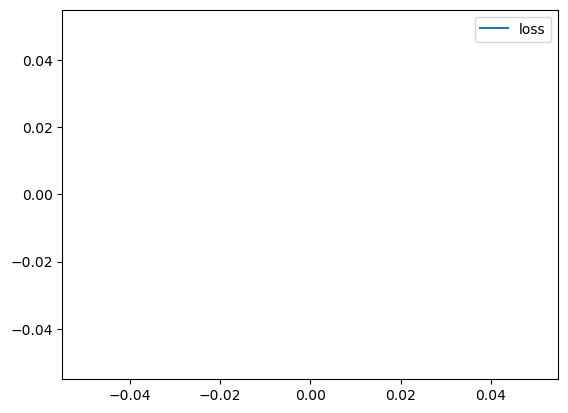

In [67]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

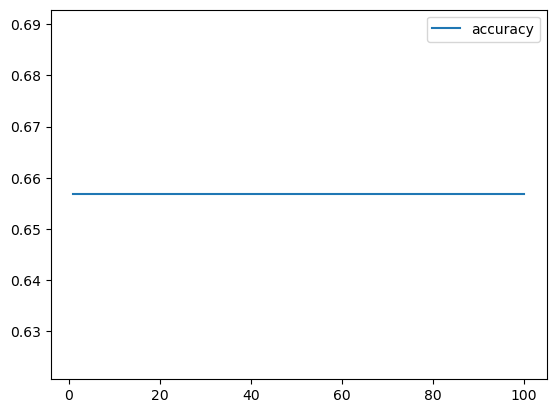

In [68]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [ ]:
# # Export our model to HDF5 file - AlphabetSoupCharity.h5
# nn.save('AlphabetSoupCharity.h5')

In [70]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  150 #len(X_train[0])/4?
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 15


nn2 = tf.keras.models.Sequential()

# First hidden layer
nn2.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn2.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 150)            │        36,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │           765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,231 (176.68 KB)

 Trainable params: 45,231 (176.68 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Compile the model
nn2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn2.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6448 - loss: nan   
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: nan
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6575 - loss: nan
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.6384 - loss: nan
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.6483 - loss: nan
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.6510 - loss: nan
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6518 - loss: nan
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.6674 - loss: nan
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.6713 - loss: nan
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6517 - loss: nan
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6482 - loss: nan
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6644 - 

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6537 - loss: nan
Epoch 71/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.6553 - loss: nan
Epoch 72/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6703 - loss: nan
Epoch 73/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6485 - loss: nan
Epoch 74/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6564 - loss: nan
Epoch 75/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6703 - loss: nan
Epoch 76/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6447 - loss: nan
Epoch 77/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.6431 - loss: nan
Epoch 78/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.6463 - loss: nan
Epoch 79/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6585 - loss: nan
Epoch 80/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.6530 - loss: nan
Epoch 81/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6543 - los

In [74]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

26/26 - 0s - 4ms/step - accuracy: 0.6256 - loss: nan
Loss: nan, Accuracy: 0.6256038546562195


In [77]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  1500 #len(X_train[0])/4?
hidden_nodes_layer2 = 500
hidden_nodes_layer3 = 25
hidden_nodes_layer4 = 10


nn3 = tf.keras.models.Sequential()

# First hidden layer
nn3.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# fourth hidden layer
nn3.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Output layer
nn3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1500)           │       369,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 500)            │       750,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 25)             │        12,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,296 (4.32 MB)

 Trainable params: 1,132,296 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Compile the model
nn3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn3.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6642 - loss: nan
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6551 - loss: nan
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6421 - loss: nan
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6413 - loss: nan
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6541 - loss: nan
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6636 - loss: nan
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6510 - loss: nan
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6741 - loss: nan
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6581 - loss: nan
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6582 - loss: nan
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6615 - loss: nan
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6564 - loss: nan
E

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6718 - loss: nan
Epoch 71/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6548 - loss: nan
Epoch 72/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6705 - loss: nan
Epoch 73/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6616 - loss: nan
Epoch 74/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6612 - loss: nan
Epoch 75/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6542 - loss: nan
Epoch 76/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6621 - loss: nan
Epoch 77/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6509 - loss: nan
Epoch 78/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6522 - loss: nan
Epoch 79/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6562 - loss: nan
Epoch 80/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6589 - loss: nan
Epoch 81/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6569 - loss: nan
Epoch

In [79]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

26/26 - 0s - 6ms/step - accuracy: 0.6256 - loss: nan
Loss: nan, Accuracy: 0.6256038546562195


In [ ]:
nn3.predict(paris_test_scaled)